## Data generation using Linear & NonLinear optimization

**disclaimer:**

The following assignment was handled on Statistics & Data analysis course taught in IDC master's studies.
The following question is being used to demonstrate the how to apply mathematical tools into a pure statistics problem insead of solving in a more traditional way by generating skewed distributions.

### Rent distributions in Randomistan
The state of Randomistan conducted a survey to study the distribution of rent paid in two neighboring towns, Stochastic Heights and Random Grove, to be denoted SH and RG.<br> 

Here are some findings of the survey:
* The population of SH and RG is 16,000 and 22,000 respectively. <br>
* The mean rent in SH and RG is 6300RCU and 4200RCU respectively.
* The median rent is 4600RCU in both towns.
* The IQR of the rent is smaller in SH than in RG.

All data generated in this question needs to be consistent with these findings.


The survey also examined the per household income (PHI) in these two places.<br>

It found that:<br>
* The mean of PHI in SH is 12500 and in RG is 8500.
* The median is 12000 in SH and 8000 in RG.
* The covariance of the rent and the PHI was observed to be as in the formula below with $\alpha=97\%$ and $\alpha=89\%$ in SH and in RG respectively.<br><br>
$$Cov(rent, PHI) = \alpha * \sqrt{Var(rent)} * \sqrt{Var(PHI)}$$

#### 2.A
Draw histograms that describe 2 different scenarii of possible distributions of rent in the two towns.Your histograms should:<br>
* Use bins of 100RCU each.
* Have at least 10 non zero bins.

#### 2.B
Draw a histogram of a third scenario with the same properties. <br>
In addition, in this scenario the rent in SH should have a higher variance than the rent in RG.

#### 2.C
Produce rent and PHI data for the two cities, that is consistent with these findings. The covariances in your data can deviate by up to 1% from the numbers given $\alpha$.

$---------------------------------------------------------------$

**SOLUTION:**

* The approach i decided to take in this specific question was a rather unique mathematical way - optimization minimization problem given subjected constraints.

* I used SciPy Optimize library and dןvided into 3 "modes" when each "mode" solves different optimization problem.

* the reason that optimization solving works here and generates different sample for each iteration is the fact that we are trying to solve Optimization problem with initial solutions. 

* for these kind of problems - the solver takes an initial guessed solution and then finds LOCAL_MINIMA and that is the reason that this mathematical methods generates each iteration different solution with given constraints.

* I solved a mathematical problem for a SAMPLE solely and then multiplied the sample to get a population. 

**first mode -> "caged": fully constrained solution**

\begin{equation*}
\begin{aligned}
& \underset{xi}{\text{minimize}}
& & \hspace{0.8cm}\sum_{i=1}^{sample} X_i\\
& \text{subject to}
& & 1)\hspace{0.5cm} \frac{\sum_{i=1}^{sample} X_i}{n} \leq  \bar{y}, \; i = 1, \ldots, sample.size\\
& & & 2)\hspace{0.5cm}median(X_i) \leq \tilde{y}, \; i = 1, \ldots, sample.
size\\
& & & 3)\hspace{0.5cm}Q_{0.75}(X_i)-Q_{0.25}(X_i)\geq IQR(y) + Const, \; i = 1, \ldots,sample.\\
& & & 4)\hspace{0.5cm}Var(X_i)\leq S(y)^2, \; i = 1, \ldots,sample.\\
\end{aligned}
\end{equation*}

**second mode -> "reg": regular constrained solution - mean and median only**

\begin{equation*}
\begin{aligned}
& \underset{xi}{\text{minimize}}
& & \hspace{0.8cm}\sum_{i=1}^{sample} X_i\\
& \text{subject to}
& & 1)\hspace{0.5cm} \frac{\sum_{i=1}^{sample} X_i}{n} \leq  \bar{y}, \; i = 1, \ldots, sample.size\\
& & & 2)\hspace{0.5cm}median(X_i) \leq \tilde{y}, \; i = 1, \ldots, sample.
size\\
\end{aligned}
\end{equation*}

**third  mode -> "covar": connect and create a relationship between X and y by subjecting an empirical covariance constrain**

\begin{equation*}
\begin{aligned}
& \underset{xi}{\text{minimize}}
& & \hspace{0.8cm}\sum_{i=1}^{sample} X_i\\
& \text{subject to}
& & 1)\hspace{0.5cm} \frac{\sum_{i=1}^{sample} X_i}{n} \leq  \bar{y}, \; i = 1, \ldots, sample.size\\
& & & 2)\hspace{0.5cm}median(X_i) \leq \tilde{y}, \; i = 1, \ldots, sample.
size\\
& & & 3)\hspace{0.5cm}Cov(X_i,y)\leq \alpha * \sqrt{Var(X_i)} * \sqrt{Var(y)}
\
\end{aligned}
\end{equation*}

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from  statistics import median
from scipy.optimize import minimize
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (8.0,6.0) 

# A demonstration how to formulate an optimization problem with constraints on python with Scipy library:

In [2]:
def generate_sample(samp_size, avg,med,c=0,min_iqr=0,vari=0,data=0,alpha=0,mode = "reg"): #generating a sample of  floats which answer specific constraints such as specific mean, median, IQR, var, covar
    a = None
    if mode == "caged": # optimization "caged" mode means that i solve opt' problem with maximum constraints such as mean,median,iqr,variance
        def objective(x,avg,med,min_iqr,vari,c):
            return x.sum()
        def constraint_avg(x):
            return x.mean() - avg
        def constraint_med(x):
            return np.median(x) - med
        def constraint_iqr(x):
            return -stats.iqr(x)+ min_iqr+c
        def constraint_var(x):
            return x.var() -vari 
        cons = [{'type':'eq', 'fun': constraint_avg},{'type':'eq', 'fun': constraint_med},{'type':'ineq', 'fun': constraint_iqr},{'type':'ineq', 'fun': constraint_var},]
        bounds = [(0, None)]
        bounds*= samp_size  # in this kind of nonlinear optimization, the final solution locate local minima,and therefore affected by intial solution     
        result = minimize( objective,np.random.randint(100,10000, size=samp_size).tolist(), constraints=cons,args=(avg,med,min_iqr,vari,c),bounds=bounds)
        a = np.array(result.x)
        
        
    if mode == "reg":  # optimization "reg" (regular) mode means that i solve opt' problem with minimum constrains - only mean and avg
        def objective(x,avg,med):
            return x.sum()
        def constraint_avg(x):
            return x.mean() - avg
        def constraint_med(x):
            return np.median(x) - med
        cons = [{'type':'eq', 'fun': constraint_avg},{'type':'eq', 'fun': constraint_med}]
        bounds = [(0, None)]
        bounds*= samp_size
        result = minimize( objective,np.random.randint(100,10000, size=samp_size).tolist(), constraints=cons,args=(avg,med),bounds=bounds)
        a = np.array(result.x)
        
        
    if mode == "covar":  # optimization "covar"  mode means that i add a constrain on the covariance and for that i get an input of alpha and additional data
        def objective(x,avg,med,data,alpha):
            return x.sum()
        def constraint_avg(x):
            return x.mean() - avg
        def constraint_med(x):
            return np.median(x) - med
        def constraint_covar(x):
            return np.cov(x, data)[0][1] - alpha * (np.var(x)**0.5) * (np.var(data)**0.5)
        # in this kind of nonlinear optimization, the final solution locate local minima,and therefore affected by intial solution
        cons = [{'type':'eq', 'fun': constraint_avg},{'type':'eq', 'fun': constraint_med},{'type':'eq', 'fun': constraint_covar}]
        bounds = [(0, None)]
        bounds*= samp_size
        result = minimize( objective,np.random.randint(100,10000, size=samp_size).tolist(), constraints=cons,args=(avg,med,data,alpha),bounds=bounds)
        a = np.array(result.x)
        
    return a

## end of optimization formulation

In [3]:
def round_to_mean(a): # a function who gets a float sample, rounds it, and add/reduce ones in order to *try* to converge to the floats mean value
    b = np.round(a,0).copy()
    if b.mean() > a.mean() :
        b[0]-=1
        if abs(b.mean()-a.mean()) >0.0000001:
            b[-1]-=1
            return b
        return b
    else:
        b[0]+=1
        if abs(b.mean()-a.mean()) >0.0000001:
            b[-1]+=1
            return b
        return b
    return b

In [4]:
def generate_int_sample(samp_size, avg,med,c=0,min_iqr=0,vari=0,data=0,alpha=0,mode = "reg"): #taking the floats generated from generate_sample and round them such that the mean is preserved
    flag = False
    num = 0
    while flag!= True and num< 1000:
        sample = generate_sample(samp_size, avg,med,c,min_iqr,vari,data,alpha,mode)
        sample_int = round_to_mean(sample)
        sample_int_mean = sample_int.mean()
        if abs(avg-sample_int_mean)< 0.0001: #  we demand really small epsilon from the mean
            flag = True
        num+=1
    if num == 1000:
        print("NO convergence")
        return None
    return sample_int

In [5]:

def create_hist(lis,population,town,num_title,detail = True):
    prop=int(population/lis.size) 
    lis = lis.tolist()
    lis*=prop
    data = pd.DataFrame(lis)
    if detail:
        med = data.median()
        mean = data.mean()
        iqr = stats.iqr(data)
        var = round(data.var(),3)
        print("{0}, Scenario {1}".format(town,num_title))
        print("Median:{0}\nMean:{1}\nIQR:{2}\nVariance:{3}".format(med[0],mean[0],iqr,var[0]))
        print("*"*30)
    return data

In [6]:
def Generate_higher_iqr(samp_size,SH_1,RG_1,iqr_sh,iqr_rg,const): # a function to iterate of generatation of higher iqr , because this constrain might diverge from time to time in nonlinear with first guessed solutions optimizations
    while (stats.iqr(SH_1) < stats.iqr(RG_1)) == False:
        SH_1 = generate_int_sample(samp_size,6300,4600,min_iqr = iqr_sh, mode = "caged")
        RG_1 = generate_int_sample(samp_size,4200,4600,c=const,min_iqr =iqr_rg, mode = "caged")
    return SH_1,RG_1


In [7]:
#Generate the data for 2.A:
SH = generate_int_sample(40,6300,4600,min_iqr =800,mode = "caged")
RG =  generate_int_sample(40,4200,4600,c = 500,min_iqr =2000,mode = "caged")
SH_1,RG_1= Generate_higher_iqr(40,SH,RG,800,2000,500)
SH = generate_int_sample(20,6300,4600,min_iqr =600,mode = "caged")
RG =  generate_int_sample(20,4200,4600,c = 500,min_iqr =2000,mode = "caged")
SH_2,RG_2= Generate_higher_iqr(20,SH,RG,600,2000,500)

SH, Scenario 1
Median:4600.0
Mean:6300.0
IQR:799.75
Variance:11804180.811
******************************
RG, Scenario 1
Median:4600.0
Mean:4200.0
IQR:2500.5
Variance:5976267.749
******************************
Does IQR of rent in RG is higher? **True**


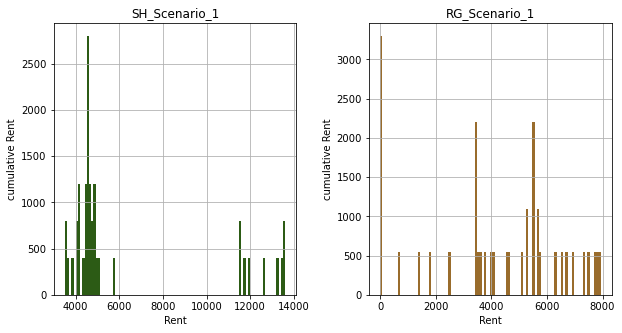

In [8]:
sh1=create_hist(SH_1,16000,"SH","1")
rg1=create_hist(RG_1,22000,"RG","1")
print("Does IQR of rent in RG is higher? **{0}**".format(stats.iqr(rg1) > stats.iqr(sh1)))
#plotting the first scenario
fig, ax =plt.subplots(1,2,figsize = (10,5))
sh1.hist(bins=100,linewidth=1,color=np.random.rand(3),ax=ax[0])
ax[0].set_title("SH_Scenario_1")
ax[0].set_xlabel('Rent')
ax[0].set_ylabel('cumulative Rent')
rg1.hist(bins=100, figsize=(9,9),linewidth=1,color=np.random.rand(3),ax=ax[1])
ax[1].set_title("RG_Scenario_1")
ax[1].set_xlabel('Rent')
ax[1].set_ylabel('cumulative Rent')
plt.show()

SH, Scenario 2
Median:4600.0
Mean:6300.0
IQR:599.25
Variance:12296072.805
******************************
RG, Scenario 2
Median:4600.0
Mean:4200.0
IQR:2500.25
Variance:7307102.741
******************************
Does IQR of rent in RG is higher? **True**


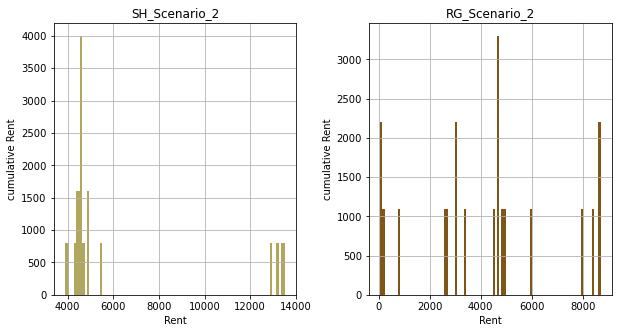

In [9]:
sh2=create_hist(SH_2,16000,"SH","2")
rg2=create_hist(RG_2,22000,"RG","2")
print("Does IQR of rent in RG is higher? **{0}**".format(stats.iqr(rg2) > stats.iqr(sh2)))   
#plotting the second scenario
fig, ax =plt.subplots(1,2,figsize = (10,5))
sh2.hist(bins=100,linewidth=1,color=np.random.rand(3),ax=ax[0])
ax[0].set_title("SH_Scenario_2")
ax[0].set_xlabel('Rent')
ax[0].set_ylabel('cumulative Rent')
rg2.hist(bins=100, figsize=(9,9),linewidth=1,color=np.random.rand(3),ax=ax[1])
ax[1].set_title("RG_Scenario_2")
ax[1].set_xlabel('Rent')
ax[1].set_ylabel('cumulative Rent')
plt.show()

In [10]:
def Generate_higher_variance(samp_size,SH_3,RG_3):# a function to iterate  generation of higher iqr & higher variance for SH , because this constrains might diverge from time to time in nonlinear with first guessed solutions optimizations
    while (np.var(SH_3) > np.var(RG_3)) == False or (stats.iqr(SH_3) < stats.iqr(RG_3)) == False:
        SH_1 = generate_int_sample(samp_size,6300,4600,min_iqr = 600,mode = "caged")
        RG_1 = generate_int_sample(samp_size,4200,4600,c=500,min_iqr =2000, mode = "caged")
    return SH_3,RG_3

In [11]:
#Generate the data for 2.B:
SH = generate_int_sample(25,6300,4600,min_iqr = 600, mode = "caged")
RG =  generate_int_sample(25,4200,4600,c=500,min_iqr =2000, mode = "caged")
SH_3,RG_3= Generate_higher_variance(25,SH,RG)

SH, Scenario 3
Median:4600.0
Mean:6300.0
IQR:600.0
Variance:9586469.714
******************************
RG, Scenario 3
Median:4600.0
Mean:4200.0
IQR:2409.0
Variance:6490545.265
******************************
Is rent in SH has a higher variance than the rent in RG? **True**


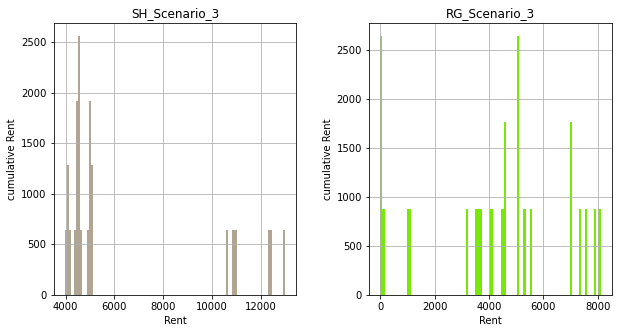

In [12]:
sh3=create_hist(SH_3,16000,"SH","3")
rg3=create_hist(RG_3,22000,"RG","3")
print("Is rent in SH has a higher variance than the rent in RG? **{0}**".format(sh3.var()[0] > rg3.var()[0]))  
#plotting the third scenario
fig, ax =plt.subplots(1,2,figsize = (10,5))
sh3.hist(bins=100,linewidth=1,color=np.random.rand(3),ax=ax[0])
ax[0].set_title("SH_Scenario_3")
ax[0].set_xlabel('Rent')
ax[0].set_ylabel('cumulative Rent')
rg3.hist(bins=100, figsize=(9,9),linewidth=1,color=np.random.rand(3),ax=ax[1])
ax[1].set_title("RG_Scenario_3")
ax[1].set_xlabel('Rent')
ax[1].set_ylabel('cumulative Rent')
plt.show()

In [13]:
calc_covar = 3
emp_covar = 2
while (100*calc_covar/emp_covar) > 101 or (100*calc_covar/emp_covar) < 99: #generate population until you less than 1% deviation
    RENT_SH = generate_int_sample(100,6300,4600,min_iqr = 600, mode = "caged")
    PHIֹ_SH = generate_int_sample(100,12500,12000,data=RENT_SH,alpha=0.97,mode = "covar")
    sh_rent=create_hist(RENT_SH,16000,"SH","Rent",detail=False)
    sh_phi=create_hist(PHIֹ_SH,16000,"SH","PHI",detail=False)
    sh_tot = pd.concat([sh_rent, sh_phi], axis=1)
    sh_tot.columns = ["rent","phi"]
    calc_covar = sh_tot.rent.cov(sh_tot.phi)
    emp_covar = np.round(0.97 * (np.var(sh_rent)**0.5) * (np.var(sh_phi)**0.5),3)[0]

The calculated covariance is 5560336.62
The empirical given covariance is 5616127.59
The covariances deviate from each other by 0.993406% < 1%


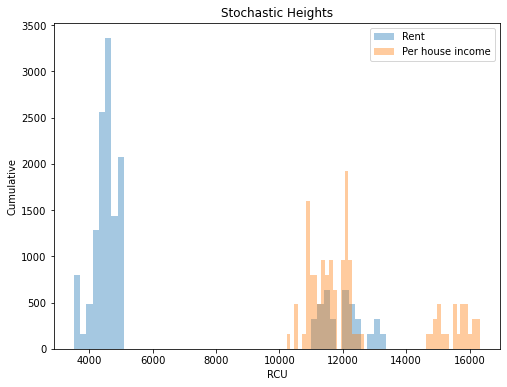

In [14]:
print("The calculated covariance is {0:.2f}".format(calc_covar))
print("The empirical given covariance is {0:.2f}".format(emp_covar))
print("The covariances deviate from each other by {0:.6f}% < 1%".format(100-100*calc_covar/emp_covar))
sns.distplot(sh_tot['rent'],  kde=False, label='Rent')
sns.distplot(sh_tot['phi'],  kde=False, label='Per house income')
plt.legend(prop={'size': 10})
plt.title('Stochastic Heights')
plt.xlabel('RCU')
plt.ylabel('Cumulative')
plt.show()